In [1]:
import os
import sys
sys.path.append("../virtuosoNet")
sys.path.append("C:\\Users\\fosca\\Desktop\\CNAM\\midi_beat_tracking\\FMP_0.1.0")
import pyScoreParser
from pathlib import Path
import pandas as pd
import music21 as m21
import pretty_midi as pm
from  matplotlib import pyplot as plt
import LibFMP.B
import LibFMP.C2
import LibFMP.C6
%matplotlib inline
import numpy as np
import math
import pandas as pd
import librosa
import soundfile

import IPython.display as ipd

## Produce downbeats and beats

In [2]:
d = {1.332: "b", 4:"bW"}
1.332 not in d

False

In [3]:
def quant_downbeat_to_annotations(midi_quant_path):
    mididata = pm.PrettyMIDI(str(midi_quant_path))
    downbeats = mididata.get_downbeats()
    #the downbeat duration (in theory)
    db_len = downbeats[2]-downbeats[1]
    downbeat = {}
    for i, db in enumerate(downbeats[:-1]):
        assert(db not in downbeat) #check if all values are uniques
        if math.isclose(downbeats[i+1]-downbeats[i], db_len, rel_tol=1e-2):
            downbeat[db] = "db"
        else:
            downbeat[db]= "dbW"
    #sort the dictionary just in case there are weird values
    ord_downbeat = {k: v for k, v in sorted(downbeat.items(), key=lambda item: item[1])}
    return ord_downbeat

def quant_beat_to_annotations(midi_quant_path):
    mididata = pm.PrettyMIDI(str(midi_quant_path))
    beats = mididata.get_beats()
    #the beat duration (in theory)
    b_len = beats[10]-beats[9] #multiple short beats in the beginning sometimes
    beat = {}
    for i, b in enumerate(beats[:-1]):
        assert(b not in beat) #check if all values are uniques
        if math.isclose(beats[i+1]-beats[i], b_len, rel_tol=1e-2):
            beat[b] = "b"
        else:
            beat[b] = "bW"
    #sort the dictionary just in case there are weird values
    ord_beat = {k: v for k, v in sorted(beat.items(), key=lambda item: item[1])}
    return beat

def aggregate_annotations(beat, downbeat):
    #merge the downbeat and the beat, with downbeat overwriting beat informations
    annotations ={**beat, **downbeat}
    return annotations

def beat_downbeat_to_text(annotations,out_path):
    path = Path(out_path)
    #produce the txt
    file_content = ""
    for a in annotations:
        file_content+= str(a) + "\t" + str(a) + "\t" + annotations[a] + "\n"
    with open(out_path,"w") as f:
        f.write(file_content)
        
def annotations_to_audio(midi_quant_path, annotations, out_path):
    midi_data = pm.PrettyMIDI(str(midi_quant_path))
    audio_fs = 22100
    beat = [a for a in annotations if annotations[a][0] == "b"]
    downbeat = [a for a in annotations if annotations[a][0] == "d"]
    midi_audio = midi_data.synthesize(fs=audio_fs)
    audio_beat = librosa.clicks(beat, sr=audio_fs, click_freq=900, length=len(midi_audio))
    audio_downbeat = librosa.clicks(downbeat, sr=audio_fs, click_freq=1200, length=len(midi_audio))
    soundfile.write(out_path,audio_beat + audio_downbeat+ midi_audio,audio_fs)

## produce for the entire dataset
Fields:
- author
- name
- folder
- performance_midi
- score_midi
- score_xml
- score2midi_alignment
- midi2midi_alignment_path
- beats
- downbeats

Dataframe problems:
- Bach/Fugue/bwv_860/midi_cleaned.mid, index: 29, the downbeat is every 3 downbeats
- Scriabin/Etudes_op_8/11/midi_cleaned.mid, index: 938, downbeat is half of the downbeat, beat is not aligned
- Bach/Fugue/bwv_857/Bult-ItoS02.mid, index: 16, beat have problems because matched with wrong note of trillo

In [4]:
def parse_folder_content(folder_path,base_path):
    #take the performance_midi
    assert(Path(base_path,folder_path.relative_to(base_path),"midi_cleaned.mid").exists())
    score_midi_path = Path(folder_path.relative_to(base_path),"midi_cleaned.mid").as_posix()
    #take the score_midi
    assert( Path(base_path,folder_path.relative_to(base_path),"musicxml_cleaned.musicxml").exists())
    score_xml_path = Path(folder_path.relative_to(base_path),"musicxml_cleaned.musicxml").as_posix()
    #find the performances
    performances_name = []
    for file in folder_path.iterdir():
        if file.suffix.lower() == ".mid" and file.name.lower() != "midi_cleaned.mid" and (not file.name.lower().endswith("xp.mid")) and file.name.lower()!="midi.mid":
            performances_name.append(file)
    #iterate over the performances
    performances = []
    for p in performances_name:
        #check if everything exists
        assert(Path(base_path,folder_path.relative_to(base_path),p.name).exists())
        print(Path(base_path,folder_path.relative_to(base_path),p.stem + "_infer_corresp.txt"))
        assert(Path(base_path,folder_path.relative_to(base_path),p.stem + "_infer_corresp.txt").exists())
        assert(Path(base_path,folder_path.relative_to(base_path),p.stem + "_infer_match.txt"))
        performances.append({
            "performer" : p.stem,
            "score_midi_path" : score_midi_path,
            "score_xml_path" : score_xml_path,
            "performed_midi_path": Path(folder_path.relative_to(base_path),p.name).as_posix(),
            "score2midi_alignment" : Path(folder_path.relative_to(base_path),p.stem + "_infer_match.txt").as_posix(),
            "midi2midi_alignment_path" : Path(folder_path.relative_to(base_path),p.stem + "_infer_corresp.txt").as_posix(),
            "folder" : Path(folder_path.relative_to(base_path)).as_posix()
        })
    return performances     

In [5]:
basepath = Path('')
for e in basepath.iterdir(): #loop on the authors
    if e.is_dir() and e.name[0] != ".":
        print(e)

Bach
Balakirev
Beethoven
Brahms
Chopin
Debussy
Glinka
Haydn
Liszt
Mozart
Prokofiev
Rachmaninoff
Ravel
Schubert
Schumann
Scriabin
util


In [6]:
#explore all the subfolders and collect the useful files name

basepath = Path('')
performances = []
for e in basepath.iterdir(): #loop on the authors
    if e.is_dir() and e.name[0] != ".":
        print("Processing", e.name)
        for ee in e.iterdir(): # loop on kind of opus or piece
            assert(ee.is_dir())
            # can be inside a piece folder or list of pieces folders
            if any([eee.is_dir() for eee in ee.iterdir()]): #this contains folder of pieces
                for eee in ee.iterdir():
                    if eee.is_dir():
                        print(e.name, eee.name)
                        print(eee.name,ee.name,e.name)
                        ps = (parse_folder_content(eee,basepath))
                        #add title and author
                        for p in ps:
                            p["title"] = ee.name+"_"+eee.name
                            p["author"] = e.name
                        performances.extend(ps)
            else: 
                ps = (parse_folder_content(ee,basepath))
                #add title and author
                for p in ps:
                    p["title"] = ee.name
                    p["author"] = e.name
                performances.extend(ps)

Processing Bach
Bach bwv_846
bwv_846 Fugue Bach
Bach\Fugue\bwv_846\Shi05_infer_corresp.txt
Bach bwv_848
bwv_848 Fugue Bach
Bach\Fugue\bwv_848\Denisova06_infer_corresp.txt
Bach\Fugue\bwv_848\Lee01_infer_corresp.txt
Bach\Fugue\bwv_848\LeeSH01_infer_corresp.txt
Bach\Fugue\bwv_848\Lin04_infer_corresp.txt
Bach\Fugue\bwv_848\Lou01_infer_corresp.txt
Bach\Fugue\bwv_848\MiyashitaM01_infer_corresp.txt
Bach\Fugue\bwv_848\Mizumoto03_infer_corresp.txt
Bach\Fugue\bwv_848\SunY01_infer_corresp.txt
Bach\Fugue\bwv_848\Zhou01_infer_corresp.txt
Bach bwv_854
bwv_854 Fugue Bach
Bach\Fugue\bwv_854\LuA01_infer_corresp.txt
Bach\Fugue\bwv_854\MiyashitaM01_infer_corresp.txt
Bach\Fugue\bwv_854\Ozaki01_infer_corresp.txt
Bach\Fugue\bwv_854\Richardson01_infer_corresp.txt
Bach\Fugue\bwv_854\WangA01_infer_corresp.txt
Bach bwv_856
bwv_856 Fugue Bach
Bach\Fugue\bwv_856\LuoJ01_infer_corresp.txt
Bach bwv_857
bwv_857 Fugue Bach
Bach\Fugue\bwv_857\Bult-ItoS02_infer_corresp.txt
Bach\Fugue\bwv_857\Lan01_infer_corresp.txt
Bach

Beethoven\Piano_Sonatas\21-1_no_repeat\SunY02_infer_corresp.txt
Beethoven\Piano_Sonatas\21-1_no_repeat\Sychev01_infer_corresp.txt
Beethoven\Piano_Sonatas\21-1_no_repeat\Tetzloff01_infer_corresp.txt
Beethoven\Piano_Sonatas\21-1_no_repeat\Tetzloff05_infer_corresp.txt
Beethoven\Piano_Sonatas\21-1_no_repeat\ToA02_infer_corresp.txt
Beethoven\Piano_Sonatas\21-1_no_repeat\TongB03_infer_corresp.txt
Beethoven\Piano_Sonatas\21-1_no_repeat\WangA02_infer_corresp.txt
Beethoven\Piano_Sonatas\21-1_no_repeat\YeZ02_infer_corresp.txt
Beethoven\Piano_Sonatas\21-1_no_repeat\YOO01_infer_corresp.txt
Beethoven\Piano_Sonatas\21-1_no_repeat\ZhangW01_infer_corresp.txt
Beethoven\Piano_Sonatas\21-1_no_repeat\Zuber01_infer_corresp.txt
Beethoven 21-2
21-2 Piano_Sonatas Beethoven
Beethoven\Piano_Sonatas\21-2\KimSY03_infer_corresp.txt
Beethoven\Piano_Sonatas\21-2\Sekino05_infer_corresp.txt
Beethoven\Piano_Sonatas\21-2\YOO05_infer_corresp.txt
Beethoven 21-3
21-3 Piano_Sonatas Beethoven
Beethoven\Piano_Sonatas\21-3\Kim

Chopin\Etudes_op_10\5\Bach02_infer_corresp.txt
Chopin\Etudes_op_10\5\Feiner_2006_02_infer_corresp.txt
Chopin\Etudes_op_10\5\KimEunhae04_infer_corresp.txt
Chopin\Etudes_op_10\5\Koshoeva02_infer_corresp.txt
Chopin\Etudes_op_10\5\LiA03_infer_corresp.txt
Chopin\Etudes_op_10\5\LIAO03_infer_corresp.txt
Chopin\Etudes_op_10\5\LiC02_infer_corresp.txt
Chopin\Etudes_op_10\5\Rozanski03_infer_corresp.txt
Chopin\Etudes_op_10\5\Tario02_infer_corresp.txt
Chopin\Etudes_op_10\5\USHIKI03_infer_corresp.txt
Chopin\Etudes_op_10\5\ZhangW03_infer_corresp.txt
Chopin 7
7 Etudes_op_10 Chopin
Chopin\Etudes_op_10\7\ChenL02_infer_corresp.txt
Chopin\Etudes_op_10\7\Namirovsky02_infer_corresp.txt
Chopin\Etudes_op_10\7\SINKEV03_infer_corresp.txt
Chopin 8
8 Etudes_op_10 Chopin
Chopin\Etudes_op_10\8\BENABD02_infer_corresp.txt
Chopin\Etudes_op_10\8\Benabdallah02_infer_corresp.txt
Chopin\Etudes_op_10\8\ChenJie03_infer_corresp.txt
Chopin\Etudes_op_10\8\CHOE01_infer_corresp.txt
Chopin\Etudes_op_10\8\FONG02_infer_corresp.txt


Liszt\Transcendental_Etudes\5\Sun09_infer_corresp.txt
Liszt\Transcendental_Etudes\5\Wang06_infer_corresp.txt
Liszt\Transcendental_Etudes\5\WangY02_infer_corresp.txt
Liszt 9
9 Transcendental_Etudes Liszt
Liszt\Transcendental_Etudes\9\ADIG07_infer_corresp.txt
Liszt\Transcendental_Etudes\9\WongDoe02_2006_infer_corresp.txt
Liszt\Transcendental_Etudes\9\WongDoe02_2009_infer_corresp.txt
Processing Mozart
Mozart\Fantasie_475\Huangci05_infer_corresp.txt
Mozart 11-3
11-3 Piano_Sonatas Mozart
Mozart\Piano_Sonatas\11-3\Stahievitch02_infer_corresp.txt
Mozart 12-1
12-1 Piano_Sonatas Mozart
Mozart\Piano_Sonatas\12-1\ADIG01_infer_corresp.txt
Mozart\Piano_Sonatas\12-1\MunA03_infer_corresp.txt
Mozart\Piano_Sonatas\12-1\TET01_infer_corresp.txt
Mozart\Piano_Sonatas\12-1\WuuE02_infer_corresp.txt
Mozart 12-2
12-2 Piano_Sonatas Mozart
Mozart\Piano_Sonatas\12-2\MunA04_infer_corresp.txt
Mozart\Piano_Sonatas\12-2\WuuE03_infer_corresp.txt
Mozart 12-3
12-3 Piano_Sonatas Mozart
Mozart\Piano_Sonatas\12-3\BLINOV01_

AssertionError: 

In [8]:
df = pd.DataFrame(performances)

df.groupby(["author","title"]).count()
df.shape
df

author                   folder  \
0         Bach       Bach/Fugue/bwv_846   
1         Bach       Bach/Fugue/bwv_848   
2         Bach       Bach/Fugue/bwv_848   
3         Bach       Bach/Fugue/bwv_848   
4         Bach       Bach/Fugue/bwv_848   
5         Bach       Bach/Fugue/bwv_848   
6         Bach       Bach/Fugue/bwv_848   
7         Bach       Bach/Fugue/bwv_848   
8         Bach       Bach/Fugue/bwv_848   
9         Bach       Bach/Fugue/bwv_848   
10        Bach       Bach/Fugue/bwv_854   
11        Bach       Bach/Fugue/bwv_854   
12        Bach       Bach/Fugue/bwv_854   
13        Bach       Bach/Fugue/bwv_854   
14        Bach       Bach/Fugue/bwv_854   
15        Bach       Bach/Fugue/bwv_856   
16        Bach       Bach/Fugue/bwv_857   
17        Bach       Bach/Fugue/bwv_857   
18        Bach       Bach/Fugue/bwv_857   
19        Bach       Bach/Fugue/bwv_857   
20        Bach       Bach/Fugue/bwv_857   
21        Bach       Bach/Fugue/bwv_857   
22        Bach       Bach/Fugue/bwv_858   
23        Bach       Bach/Fugue/bwv_858   
24        Bach       Bach/Fugue/bwv_860   
25        Bach       Bach/Fugue/bwv_860   
26        Bach       Bach/Fugue/bwv_860   
27        Bach       Bach/Fugue/bwv_860   
28        Bach       Bach/Fugue/bwv_860   
29        Bach       Bach/Fugue/bwv_860   
...        ...                      ...   
1074  Schumann  Schumann/Kreisleriana/4   
1075  Schumann  Schumann/Kreisleriana/4   
1076  Schumann  Schumann/Kreisleriana/5   
1077  Schumann  Schumann/Kreisleriana/5   
1078  Schumann  Schumann/Kreisleriana/5   
1079  Schumann  Schumann/Kreisleriana/6   
1080  Schumann  Schumann/Kreisleriana/6   
1081  Schumann  Schumann/Kreisleriana/6   
1082  Schumann  Schumann/Kreisleriana/7   
1083  Schumann  Schumann/Kreisleriana/7   
1084  Schumann  Schumann/Kreisleriana/7   
1085  Schumann         Schumann/Toccata   
1086  Schumann         Schumann/Toccata   
1087  Schumann         Schumann/Toccata   
1088  Schumann         Schumann/Toccata   
1089  Schumann  Schumann/Toccata_repeat   
1090  Schumann  Schumann/Toccata_repeat   
1091  Scriabin  Scriabin/Etudes_op_8/11   
1092  Scriabin  Scriabin/Etudes_op_8/11   
1093  Scriabin  Scriabin/Etudes_op_8/11   
1094  Scriabin       Scriabin/Sonatas/5   
1095  Scriabin       Scriabin/Sonatas/5   
1096  Scriabin       Scriabin/Sonatas/5   
1097  Scriabin       Scriabin/Sonatas/5   
1098  Scriabin       Scriabin/Sonatas/5   
1099  Scriabin       Scriabin/Sonatas/5   
1100  Scriabin       Scriabin/Sonatas/5   
1101  Scriabin       Scriabin/Sonatas/5   
1102  Scriabin       Scriabin/Sonatas/5   
1103  Scriabin       Scriabin/Sonatas/5   

                               midi2midi_alignment_path  \
0            Bach/Fugue/bwv_846/Shi05_infer_corresp.txt   
1       Bach/Fugue/bwv_848/Denisova06_infer_corresp.txt   
2            Bach/Fugue/bwv_848/Lee01_infer_corresp.txt   
3          Bach/Fugue/bwv_848/LeeSH01_infer_corresp.txt   
4            Bach/Fugue/bwv_848/Lin04_infer_corresp.txt   
5            Bach/Fugue/bwv_848/Lou01_infer_corresp.txt   
6     Bach/Fugue/bwv_848/MiyashitaM01_infer_corresp.txt   
7       Bach/Fugue/bwv_848/Mizumoto03_infer_corresp.txt   
8           Bach/Fugue/bwv_848/SunY01_infer_corresp.txt   
9           Bach/Fugue/bwv_848/Zhou01_infer_corresp.txt   
10           Bach/Fugue/bwv_854/LuA01_infer_corresp.txt   
11    Bach/Fugue/bwv_854/MiyashitaM01_infer_corresp.txt   
12         Bach/Fugue/bwv_854/Ozaki01_infer_corresp.txt   
13    Bach/Fugue/bwv_854/Richardson01_infer_corresp.txt   
14         Bach/Fugue/bwv_854/WangA01_infer_corresp.txt   
15          Bach/Fugue/bwv_856/LuoJ01_infer_corresp.txt   
16     Bach/Fugue/bwv_857/Bult-ItoS02_infer_corresp.txt   
17           Bach/Fugue/bwv_857/Lan01_infer_corresp.txt   
18      Bach/Fugue/bwv_857/Lisiecki04_infer_corresp.txt   
19           Bach/Fugue/bwv_857/ToA01_infer_corresp.txt   
20         Bach/Fugue/bwv_857/WangA01_infer_corresp.txt   
21           Bach/Fugue/bwv_857/YuP01_infer

In [14]:
df[df["folder"]=="Schubert/Piano_Sonatas/664-3"]

author                        folder  \
1049  Schubert  Schubert/Piano_Sonatas/664-3   
1050  Schubert  Schubert/Piano_Sonatas/664-3   

                               midi2midi_alignment_path  \
1049  Schubert/Piano_Sonatas/664-3/KabuliL12_infer_c...   
1050  Schubert/Piano_Sonatas/664-3/Lin07_infer_corre...   

                             performed_midi_path  performer  \
1049  Schubert/Piano_Sonatas/664-3/KabuliL12.mid  KabuliL12   
1050      Schubert/Piano_Sonatas/664-3/Lin07.mid      Lin07   

                                   score2midi_alignment  \
1049  Schubert/Piano_Sonatas/664-3/KabuliL12_infer_m...   
1050  Schubert/Piano_Sonatas/664-3/Lin07_infer_match...   

                                    score_midi_path  \
1049  Schubert/Piano_Sonatas/664-3/midi_cleaned.mid   
1050  Schubert/Piano_Sonatas/664-3/midi_cleaned.mid   

                                         score_xml_path                title  
1049  Schubert/Piano_Sonatas/664-3/musicxml_cleaned....  Piano_Sonatas_664-3  
1050  Schubert/Piano_Sonatas/664-3/musicxml_cleaned....  Piano_Sonatas_664-3

In [17]:
df_folder = df.drop_duplicates(subset=["folder"])[["folder"]].reset_index(drop=True).rename(columns={"folder": "opus"})
df_folder["done"] = [False for i in df_folder.iterrows()]
df_folder

#save as excel
df_folder.to_excel("output.xlsx")

In [7]:
from collections import Counter
Counter(df["author"]).keys()

dict_keys(['Bach', 'Balakirev', 'Beethoven', 'Brahms', 'Chopin', 'Debussy', 'Glinka', 'Haydn', 'Liszt', 'Mozart', 'Prokofiev', 'Rachmaninoff', 'Ravel', 'Schubert', 'Schumann', 'Scriabin'])

In [31]:
# WRITE FILES IN THE DATASET. Uncomment the last two lines to write them

def row_to_quant_ann(row):
    dbs = quant_downbeat_to_annotations(row["score_midi_path"])
    bs = quant_beat_to_annotations(row["score_midi_path"])
    anns = aggregate_annotations(bs,dbs)
    beat_downbeat_to_text(anns, str(Path(row["folder"],"ann_quant.txt")))
    annotations_to_audio(row["score_midi_path"],anns,str(Path(row["folder"],"quant_click.wav")))

# for i,row in df.drop_duplicates(subset ="score_midi_path", keep = "first", inplace = False).iterrows():
#     row_to_quant_ann(row)

C:\Users\fosca\Anaconda3\envs\music_env\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [21]:
df.drop_duplicates(subset=["title"]).groupby("author").count()

folder  midi2midi_alignment_path  performed_midi_path  \
author                                                                
Bach              59                        59                   59   
Balakirev          1                         1                    1   
Beethoven         64                        64                   64   
Brahms             1                         1                    1   
Chopin            36                        36                   36   
Debussy            2                         2                    2   
Glinka             1                         1                    1   
Haydn             12                        12                   12   
Liszt             16                        16                   16   
Mozart             3                         3                    3   
Prokofiev          1                         1                    1   
Rachmaninoff       5                         5                    5   
Ravel              5                         5                    5   
Schubert          15                        15                   15   
Schumann          10                        10                   10   
Scriabin           2                         2                    2   

              performer  score2midi_alignment  score_midi_path  \
author                                                           
Bach                 59                    59               59   
Balakirev             1                     1                1   
Beethoven            64                    64               64   
Brahms                1                     1                1   
Chopin               36                    36               36   
Debussy               2                     2                2   
Glinka                1                     1                1   
Haydn                12                    12               12   
Liszt                16                    16               16   
Mozart                3                     3                3   
Prokofiev             1                     1                1   
Rachmaninoff          5                     5                5   
Ravel                 5                     5                5   
Schubert             15                    15               15   
Schumann             10                    10               10   
Scriabin              2                     2                2   

              score_xml_path  title  
author                               
Bach                      59     59  
Balakirev                  1      1  
Beethoven                 64     64  
Brahms                     1      1  
Chopin                    36     36  
Debussy                    2      2  
Glinka                     1      1  
Haydn                     12     12  
Liszt                     16     16  
Mozart                     3      3  
Prokofiev                  1      1  
Rachmaninoff               5      5  
Ravel                      5      5  
Schubert                  15     15  
Schumann                  10     10  
Scriabin                   2      2

### Produce annotations for a single song

In [51]:
#PAVANE, df index 997,998
# the beats and downbeats extracted are not aligned. Maybe it depends on tempo changes, so let's try to remove them

row = df.iloc[998]

score_path = row["score_midi_path"]
score2midi_path = row["midi2midi_alignment_path"]
midi2midi_path = row["score2midi_alignment"]
midi_quant_path = row["score_midi_path"]

#open the midi
tempo_changes = mididata.get_tempo_changes()
print(tempo_changes)
downbeats = mididata.get_downbeats()

midi_data = pm.PrettyMIDI(str(midi_quant_path))
audio_fs = 22100
midi_audio = midi_data.synthesize(fs=audio_fs)[0: 20*audio_fs]
audio_beat = librosa.clicks(midi_data.get_beats(), sr=audio_fs, click_freq=900, length=len(midi_audio))
audio_downbeat = librosa.clicks(midi_data.get_downbeats(), sr=audio_fs, click_freq=1200, length=len(midi_audio))

ipd.display(ipd.Audio(audio_beat + audio_downbeat+ midi_audio,rate =audio_fs))


dbs = quant_downbeat_to_annotations(midi_quant_path)
bs = quant_beat_to_annotations(midi_quant_path)
anns = aggregate_annotations(bs,dbs)
beat_downbeat_to_text(anns, str(Path(row["folder"],"ann_quant.txt")))
annotations_to_audio(row["score_midi_path"],anns,str(Path(row["folder"],"quant_click.wav")))

(array([0.]), array([190.000285]))


C:\Users\fosca\Anaconda3\envs\music_env\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [13]:
# Schubert/Impromptu_op.90_D.899/1, df index 999-1002
# the beats and downbeats extracted are aligned with the audio produced by the midi, but not in sync with the midi:/ Let's try to recompile them
row = df.iloc[999]

score_path = row["score_midi_path"]
score2midi_path = row["midi2midi_alignment_path"]
midi2midi_path = row["score2midi_alignment"]
midi_quant_path = row["score_midi_path"]

print("processing score", score_path)

midi_data = pm.PrettyMIDI(str(midi_quant_path))

#open the midi
tempo_changes = midi_data.get_tempo_changes()
print(tempo_changes)
downbeats = midi_data.get_downbeats()


audio_fs = 22100
midi_audio = midi_data.synthesize(fs=audio_fs)[0: 20*audio_fs]
audio_beat = librosa.clicks(midi_data.get_beats(), sr=audio_fs, click_freq=900, length=len(midi_audio))
audio_downbeat = librosa.clicks(midi_data.get_downbeats(), sr=audio_fs, click_freq=1200, length=len(midi_audio))

ipd.display(ipd.Audio(audio_beat + audio_downbeat+ midi_audio,rate =audio_fs))


dbs = quant_downbeat_to_annotations(midi_quant_path)
bs = quant_beat_to_annotations(midi_quant_path)
anns = aggregate_annotations(bs,dbs)
beat_downbeat_to_text(anns, str(Path(row["folder"],"ann_quant.txt")))
annotations_to_audio(row["score_midi_path"],anns,str(Path(row["folder"],"quant_click.wav")))

# PROBLEM NOT SOLVED. VERY WEIRD!!!!!!!!!!!!!!!!!!!!!!!!!!!

processing score Schubert/Impromptu_op.90_D.899/1/midi_cleaned.mid
(array([0. , 1.5]), array([120.       ,  77.9999766]))


C:\Users\fosca\Anaconda3\envs\music_env\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [20]:
# Schubert/Piano_Sonatas/664-3, df index 1049,1050
# the beats and downbeats extracted are in 4/4. I re exported the midi in 6/8 (correct ts) and now we need the beat again

row = df.iloc[1049]

score_path = row["score_midi_path"]
score2midi_path = row["midi2midi_alignment_path"]
midi2midi_path = row["score2midi_alignment"]
midi_quant_path = row["score_midi_path"]

print("processing score", score_path)

midi_data = pm.PrettyMIDI(str(midi_quant_path))

#open the midi
tempo_changes = midi_data.get_tempo_changes()
print(tempo_changes)
downbeats = midi_data.get_downbeats()


audio_fs = 22100
midi_audio = midi_data.synthesize(fs=audio_fs)[0: 20*audio_fs]
audio_beat = librosa.clicks(midi_data.get_beats(), sr=audio_fs, click_freq=900, length=len(midi_audio))
audio_downbeat = librosa.clicks(midi_data.get_downbeats(), sr=audio_fs, click_freq=1200, length=len(midi_audio))

ipd.display(ipd.Audio(audio_beat + audio_downbeat+ midi_audio,rate =audio_fs))


dbs = quant_downbeat_to_annotations(midi_quant_path)
bs = quant_beat_to_annotations(midi_quant_path)
anns = aggregate_annotations(bs,dbs)


#correct the 6/8 bug adding db annotations
for i,k in enumerate(anns.keys()):
    if i%2 == 1 and anns[k] == "b":
        anns[k] = "db"
        
print(anns)


beat_downbeat_to_text(anns, str(Path(row["folder"],"ann_quant.txt")))
annotations_to_audio(row["score_midi_path"],anns,str(Path(row["folder"],"quant_click.wav")))


processing score Schubert/Piano_Sonatas/664-3/midi_cleaned.mid
(array([0.]), array([85.0000425]))


C:\Users\fosca\Anaconda3\envs\music_env\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


{0.0: 'dbW', 0.352941: 'bW', 0.705882: 'bW', 1.0588229999999998: 'db', 2.1176459999999997: 'b', 3.176469: 'db', 4.235292: 'b', 5.294115000000001: 'db', 6.352938000000001: 'b', 7.411761000000001: 'db', 8.470584: 'b', 9.529407: 'db', 10.588230000000001: 'b', 11.647053000000001: 'db', 12.705876000000002: 'b', 13.764699000000002: 'db', 14.823522000000002: 'b', 15.882345000000003: 'db', 16.941168: 'b', 17.999991: 'db', 19.058814: 'b', 20.117637000000002: 'db', 21.176460000000002: 'b', 22.235283000000003: 'db', 23.294106000000003: 'b', 24.352929000000003: 'db', 25.411752000000003: 'b', 26.470575000000004: 'db', 27.529398000000004: 'b', 28.588221000000004: 'db', 29.647044000000005: 'b', 30.705867000000005: 'db', 31.764690000000005: 'b', 32.823513000000005: 'db', 33.882336: 'b', 34.941159: 'db', 35.999981999999996: 'b', 37.05880499999999: 'db', 38.11762799999999: 'b', 39.176450999999986: 'db', 40.23527399999998: 'b', 41.29409699999998: 'db', 42.352919999999976: 'b', 43.41174299999997: 'db', 44

In [36]:
#add the beat

BASE_PATH = Path('virtuosonet_xmlmidi/') 

def row_to__unquantized_beat(row):
    m2m_p = Path(BASE_PATH, row["midi2midi_alignment_path"])
    m2mdf = cleaned_m2m_df(m2m_p)
    try:
        cl_q_b = cleaned_quant_beat(Path(BASE_PATH,row["score_midi_path"]))
        cl_u_b = cleaned_unquant_beat(m2mdf,cl_q_b)
        return cl_u_b
    except ValueError:
        print("Failed for song",row["title"])
        return None
    return None


good_df["performed_beat"] = df.apply(row_to__unquantized_beat,axis=1)

NameError: ("name 'cleaned_m2m_df' is not defined", 'occurred at index 0')

In [ ]:
good_df

In [29]:
#visualization and sonification function

def sonify_peaks(midi_path,interval,peaks_sec,audio_fs):
    midi_data = pm.PrettyMIDI(str(midi_path))
    #compute audio
    audio_data = midi_data.synthesize(fs=audio_fs)[interval[0]*audio_fs:interval[1]*audio_fs]
    x_peaks = librosa.clicks(peaks_sec, sr=audio_fs, click_freq=1000, length=len(audio_data))
    ipd.display(ipd.Audio(audio_data + x_peaks,rate =audio_fs))

def visualize_from_df(index,df,interval,mark_type):
    if mark_type == "beat":
        marks = df["performed_beat"].loc[index]
    elif mark_type == "downbeat":
        marks = df["performed_downbeat"].loc[index]
    else:
        raise TypeError("The mark type can be either 'beat' or 'downbeat'")
    performed_midi_path = Path(BASE_PATH,df["performed_midi_path"].loc[index])
    sonify_peaks(performed_midi_path,interval,marks, AUDIO_FS)
    visualize_on_pianoroll(performed_midi_path, marks,interval[0],interval[1])

BASE_PATH = Path('virtuosonet_xmlmidi/') 
AUDIO_FS = 22050


In [30]:
#big problem with ternary/binary metric
visualize_from_df(938,df, (0,30),"downbeat")

KeyError: 'performed_downbeat'

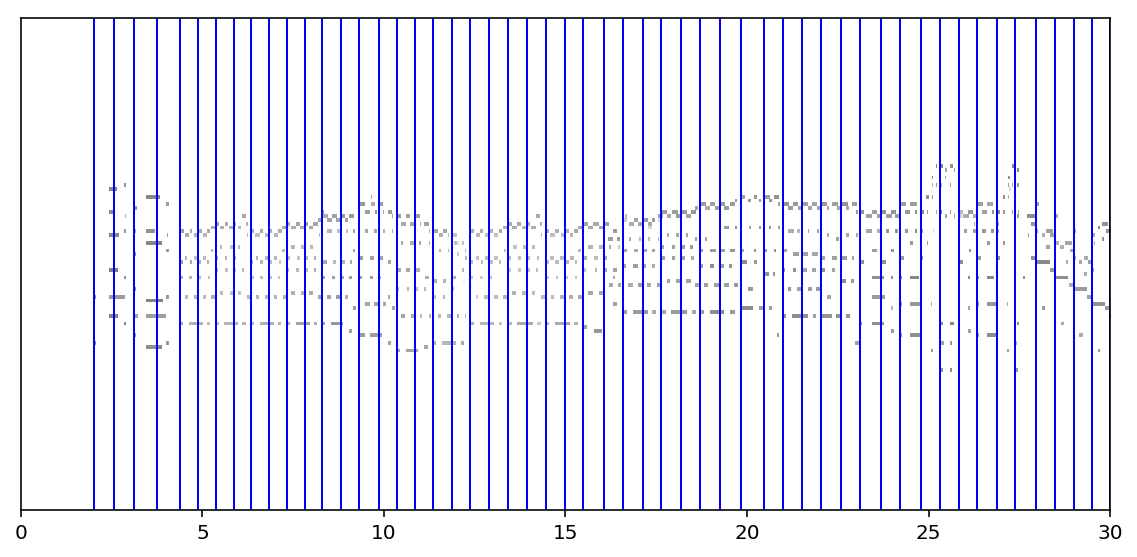

In [202]:
visualize_from_df(936,good_df, (0,30),"beat")

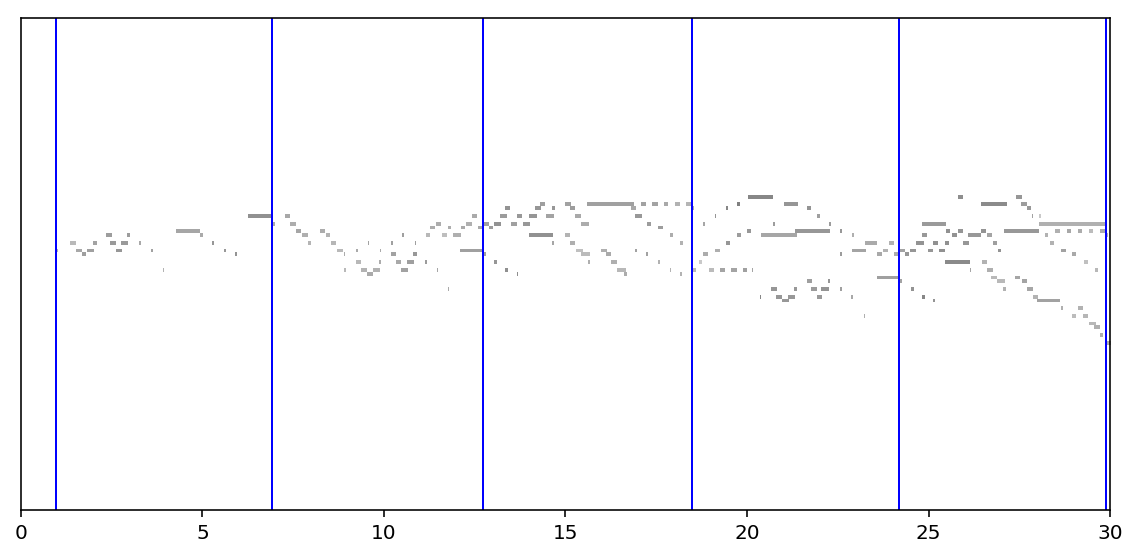

In [229]:
#problem with the downbeat too sparse

visualize_from_df(29,good_df, (0,30),"downbeat")

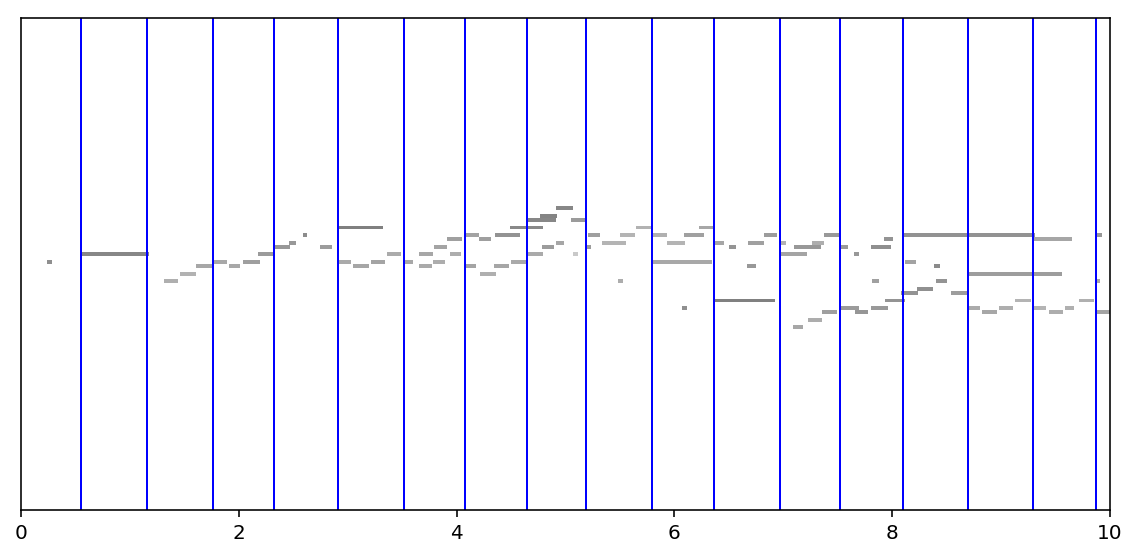

In [225]:
visualize_from_df(10,good_df, (0,10),"beat")

In [245]:
good_df

author                           midi2midi_alignment_path  \
0        Bach         Bach/Fugue/bwv_846/Shi05_infer_corresp.txt   
1        Bach    Bach/Fugue/bwv_848/Denisova06_infer_corresp.txt   
2        Bach         Bach/Fugue/bwv_848/Lee01_infer_corresp.txt   
3        Bach       Bach/Fugue/bwv_848/LeeSH01_infer_corresp.txt   
4        Bach         Bach/Fugue/bwv_848/Lin04_infer_corresp.txt   
5        Bach         Bach/Fugue/bwv_848/Lou01_infer_corresp.txt   
6        Bach  Bach/Fugue/bwv_848/MiyashitaM01_infer_corresp.txt   
7        Bach    Bach/Fugue/bwv_848/Mizumoto03_infer_corresp.txt   
8        Bach        Bach/Fugue/bwv_848/SunY01_infer_corresp.txt   
9        Bach        Bach/Fugue/bwv_848/Zhou01_infer_corresp.txt   
10       Bach         Bach/Fugue/bwv_854/LuA01_infer_corresp.txt   
11       Bach  Bach/Fugue/bwv_854/MiyashitaM01_infer_corresp.txt   
12       Bach       Bach/Fugue/bwv_854/Ozaki01_infer_corresp.txt   
13       Bach  Bach/Fugue/bwv_854/Richardson01_infer_corresp.txt   
14       Bach       Bach/Fugue/bwv_854/WangA01_infer_corresp.txt   
15       Bach        Bach/Fugue/bwv_856/LuoJ01_infer_corresp.txt   
16       Bach   Bach/Fugue/bwv_857/Bult-ItoS02_infer_corresp.txt   
17       Bach         Bach/Fugue/bwv_857/Lan01_infer_corresp.txt   
18       Bach    Bach/Fugue/bwv_857/Lisiecki04_infer_corresp.txt   
19       Bach         Bach/Fugue/bwv_857/ToA01_infer_corresp.txt   
20       Bach       Bach/Fugue/bwv_857/WangA01_infer_corresp.txt   
21       Bach         Bach/Fugue/bwv_857/YuP01_infer_corresp.txt   
22       Bach         Bach/Fugue/bwv_858/VuV01_infer_corresp.txt   
23       Bach       Bach/Fugue/bwv_858/Zhang01_infer_corresp.txt   
24       Bach          Bach/Fugue/bwv_860/Ko04_infer_corresp.txt   
25       Bach   Bach/Fugue/bwv_860/Nikiforov05_infer_corresp.txt   
26       Bach    Bach/Fugue/bwv_860/Tetzloff04_infer_corresp.txt   
27       Bach       Bach/Fugue/bwv_860/TuanS01_infer_corresp.txt   
28       Bach      Bach/Fugue/bwv_860/YoungS01_infer_corresp.txt   
29       Bach      Bach/Fugue/bwv_860/ZhangH04_infer_corresp.txt   
..        ...                                                ...   
903  Schubert  Schubert/Impromptu_op142/3/WangH06_infer_corre...   
904  Schubert  Schubert/Impromptu_op142/3/YoungS06_infer_corr...   
905  Schubert  Schubert/Moment_Musical_no_1/MunA10_infer_corr...   
906  Schubert  Schubert/Moment_musical_no_3/Tetzloff09_infer_...   
907  Schubert  Schubert/Piano_Sonatas/664-1/BuiJL06_infer_cor...   
908  Schubert  Schubert/Piano_Sonatas/664-1/KabuliL10_infer_c...   
909  Schubert  Schubert/Piano_Sonatas/664-1/Lin07_infer_corre...   
910  Schubert  Schubert/Piano_Sonatas/664-1/Mo10_infer_corres...   
911  Schubert  Schubert/Piano_Sonatas/664-2/KabuliL11_infer_c...   
912  Schubert  Schubert/Piano_Sonatas/664-2/Lin07_infer_corre...   
914  Schubert  Schubert/Piano_Sonatas/664-3/Lin07_infer_corre...   
915  Schubert  Schubert/Piano_Sonatas/894-2/KimSY16_infer_cor...   
916  Schubert  Schubert/Piano_Sonatas/894-2/LEE_K08_infer_cor...   
917  Schubert  Schubert/Piano_Sonatas/894-2/Yeletskiy08_infer...   
918  Schubert  Schubert/Piano_Sonatas/894-2_no_repeat/BianF14...   
919  Schubert  Schubert/Piano_Sonatas/894-2_no_repeat/Chan01_...   
920  Schubert  Schubert/Piano_Sonatas/894-2_no_repeat/CHEN11_...   
921  Schubert  Schubert/Piano_Sonatas/894-2_no_repeat/HouY09_...   
922  Schubert  Schubert/Piano_Sonatas/894-2_no_repeat/Lee10_i...   
923  Schubert  Schubert/Piano_Sonatas/894-2_no_repeat/SINKEV1...   
927  Schumann  Schumann/Kreisleriana/1/Yarden09_infer_corresp...   
929  Schumann  Schumann/Kreisleriana/3/Yarden09_infer_corresp...   
930  Schumann  Schumann/Kreisleriana/4/Yarden09_infer_corresp...   
931  Schumann  Schumann/Kreisleriana/5/Yarden09_infer_corresp...   
933  Schumann  Schumann/Kreisleriana/7/Yarden09_infer_corresp...   
934  Schumann        Schumann/Toccata/BENABD04_infer_corresp.txt   
935  Schumann        Schumann/Toccata/BENABD10_infer_corresp.tx

In [238]:
print(good_df.shape)
good_df = good_df[good_df["performed_beat"].notnull()]
print(good_df.shape)

(550, 10)
(545, 10)


In [239]:
good_df.to_pickle("cleaned_virtuosonet.pickle")

## Check the quality of df

In [240]:
df = pd.read_pickle("cleaned_virtuosonet.pickle")

In [266]:
df.loc[291]

author                                                              Beethoven
midi2midi_alignment_path    Beethoven/Piano_Sonatas/24-1/DeTurck06_infer_c...
performed_midi_path                Beethoven/Piano_Sonatas/24-1/DeTurck06.mid
performer                                                           DeTurck06
score2midi_alignment        Beethoven/Piano_Sonatas/24-1/DeTurck06_infer_m...
score_midi_path                 Beethoven/Piano_Sonatas/24-1/midi_cleaned.mid
score_xml_path              Beethoven/Piano_Sonatas/24-1/musicxml_cleaned....
title                                                      Piano_Sonatas_24-1
performed_downbeat          [1.2339725, 3.5265077499999995, 5.819042999999...
performed_beat              [1.2339725, 1.627232894736842, 2.0204932894736...
Name: 291, dtype: object

In [250]:
#check if all the downbeats are beats
for i,r in df.iterrows():
    if all([db in r["performed_beat"] for db in r["performed_downbeat"]]):
        print(i, True)
    else:
        unaligned = []
        for db in r["performed_downbeat"]:
            if db not in r["performed_beat"]:
                unaligned.append(db)
        print(i, unaligned)
            

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 [21.826175]
17 [19.924425]
18 True
19 [25.48375]
20 True
21 [22.623150000000003]
22 True
23 True
24 [119.954]
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 [4.160315]
43 [2.8889050000000003]
44 [2.76282]
45 True
46 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
63 True
64 [148.8245, 158.82925]
65 [133.40425, 143.20499999999998]
66 [159.79649999999998, 171.96783333333332]
67 [131.26512499999998, 140.51983333333334]
68 [128.57399999999998, 138.63958333333335]
69 [122.112875, 131.82875]
70 True
72 True
73 True
74 True
75 True
76 True
77 True
78 [251.34433333333334, 252.22466666666665]
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 Tr

356 [4.265772380952381, 7.006104761904762, 9.746437142857143, 12.486769523809524, 15.227101904761906, 17.967434285714287, 24.6906, 26.5941, 30.3819375, 32.266275, 34.1506125, 38.0281375, 40.021325000000004, 42.0145125, 45.780550000000005, 54.60395, 58.157650000000004, 62.3931, 66.87242499999999, 68.87045, 70.868475, 75.07114166666668, 77.27578333333334, 81.499565625, 83.51870625000001, 85.53784687500001, 87.5569875, 89.576128125, 91.59526875, 93.61440937500001, 97.98568571428571, 100.33782142857143, 102.68995714285714, 105.04209285714286, 107.39422857142857, 109.7463642857143, 116.19066666666666, 118.08283333333333, 122.324, 124.673, 127.022, 131.67112500000002, 133.97125, 136.271375, 140.56866666666667, 142.56583333333333, 148.369, 150.258, 154.15025000000003, 156.1535, 158.15675000000002, 162.04325, 163.9265, 165.80975, 169.5293333333333, 171.36566666666667, 177.35399999999998, 179.448, 183.46699999999998, 187.203, 190.7825, 194.33849999999998, 198.5025, 207.40966666666668, 209.32333

385 [4.966308461538462, 7.631599423076924, 10.296890384615386, 12.962181346153848, 15.62747230769231, 18.292763269230772, 20.958054230769235, 23.623345192307696, 26.288636153846156, 28.95392711538462, 31.619218076923083, 34.28450903846154, 39.66479230769231, 42.379784615384615, 45.09477692307692, 47.809769230769234, 50.52476153846153, 53.239753846153846, 55.95474615384615, 58.66973846153846, 61.384730769230764, 64.09972307692307, 66.81471538461538, 69.52970769230768, 78.73840714285714, 80.83943928571428, 82.94047142857143, 85.04150357142856, 87.14253571428571, 89.24356785714285, 92.94056338028169, 94.53652676056338, 96.13249014084506, 97.72845352112677, 99.32441690140845, 100.92038028169014, 102.51634366197183, 104.11230704225352, 105.70827042253521, 107.3042338028169, 108.90019718309858, 110.49616056338027, 112.09212394366196, 113.68808732394366, 115.28405070422535, 116.88001408450704, 118.47597746478873, 120.07194084507042, 121.66790422535212, 123.2638676056338, 124.8598309859155, 12

400 [10.983740000000001, 13.494185, 16.00463, 18.515075, 21.02552, 23.535964999999997, 26.046409999999998, 28.556855, 41.6420875, 44.256575, 46.871062499999994, 49.485549999999996, 52.1000375, 57.23221666666666, 59.74990833333333, 62.267599999999995, 64.78529166666667, 67.30298333333333, 69.820675, 72.33836666666667, 74.85605833333334, 87.38829999999999, 89.7199, 92.0515, 94.3831, 96.7147, 101.3622888888889, 103.67827777777778, 105.99426666666668, 108.31025555555556, 110.62624444444445, 112.94223333333333, 115.25822222222223, 117.57421111111111, 122.04604444444445, 124.20188888888889, 126.35773333333334, 128.51357777777778, 130.66942222222224, 132.82526666666666, 134.98111111111112, 137.13695555555555, 141.64182222222223, 143.99084444444443, 146.33986666666667, 148.6888888888889, 151.0379111111111, 153.38693333333333, 155.73595555555556, 158.08497777777777, 162.41983333333334, 164.40566666666666, 168.3516666666667, 170.31183333333334, 174.24816666666666, 176.22433333333333, 180.3244999

651 True
652 True
653 True
654 [100.23574285714284, 118.716, 120.757, 122.798, 124.839, 126.88, 128.921, 130.962, 133.00300000000001, 135.044, 137.085, 146.7569, 150.78265, 154.44688888888888, 156.14627777777778, 157.84566666666666, 159.54505555555556, 161.24444444444444, 162.94383333333334, 164.64322222222222, 166.34261111111113, 169.6692857142857, 172.48751428571424, 174.4874571428571, 176.48739999999998, 178.48734285714283, 180.4872857142857, 182.48722857142855, 184.4871714285714, 186.48711428571428, 188.48705714285714, 200.40322727272726, 202.10845454545452, 203.8136818181818, 205.5189090909091, 207.22413636363635, 208.92936363636363, 210.6345909090909, 212.33981818181817, 214.04504545454546, 215.75027272727272, 225.68220000000002, 227.2964, 228.9106, 230.5248, 232.139, 233.7532, 235.36739999999998, 236.9816, 238.5958, 250.48835, 252.4842, 254.48005, 256.47589999999997, 258.47175, 260.4676, 262.46344999999997, 264.4593, 266.45514999999995, 280.30050000000006, 282.3616666666667, 284

698 [10.270416, 13.447425333333333, 16.624434666666666, 19.801444, 22.978453333333334, 26.155462666666665, 29.332472, 32.50948133333333, 35.68649066666667, 41.489650000000005, 44.1158, 46.74195, 49.368100000000005, 51.99425000000001, 54.620400000000004, 57.246550000000006, 59.87270000000001, 62.498850000000004, 65.125, 67.75115000000001, 70.3773, 73.00345000000002, 75.62960000000001, 100.2475568181818, 102.15086363636362, 104.05417045454544, 105.95747727272726, 107.86078409090908, 109.7640909090909, 111.66739772727273, 113.57070454545455, 115.47401136363636, 117.37731818181818, 119.280625, 121.18393181818182, 123.08723863636364, 124.99054545454545, 126.89385227272729, 128.7971590909091, 130.70046590909092, 132.60377272727274, 134.50707954545456, 136.41038636363638, 138.3136931818182, 144.23422222222223, 145.71744444444445, 147.20066666666668, 148.6838888888889, 150.1671111111111, 151.65033333333332, 153.13355555555555, 154.61677777777777, 159.09355555555555, 160.5561111111111, 162.0186

705 [7.140523999999999, 10.239554666666667, 13.338585333333333, 16.437616, 19.536646666666662, 22.635677333333334, 25.734707999999998, 28.83373866666666, 31.932769333333333, 37.63093, 40.23006, 42.82919, 45.42832, 48.02745, 50.626580000000004, 53.22571000000001, 55.82484000000001, 58.42397000000001, 61.02310000000001, 63.62223000000001, 66.22136, 68.82049, 71.41962000000001, 97.15302727272727, 99.17845454545454, 101.20388181818183, 103.2293090909091, 105.25473636363637, 107.28016363636364, 109.30559090909091, 111.3310181818182, 113.35644545454547, 115.38187272727274, 117.4073, 119.43272727272728, 121.45815454545456, 123.48358181818182, 125.5090090909091, 127.53443636363637, 129.55986363636364, 131.58529090909093, 133.61071818181819, 135.63614545454547, 137.66157272727276, 143.98711111111112, 145.61822222222222, 147.24933333333334, 148.88044444444444, 150.51155555555556, 152.14266666666666, 153.77377777777778, 155.40488888888888, 160.12877777777777, 161.73355555555557, 163.3383333333333

830 [166.93395833333332, 172.88599999999997]
831 [102.4717]
832 True
833 True
834 [115.18763333333334]
835 True
836 True
837 True
838 True
839 True
840 True
841 True
842 True
843 True
844 True
845 True
846 True
847 True
848 True
849 True
850 True
851 True
852 True
853 True
855 [94.29665]
856 [230.259, 232.492, 248.1278333333333, 249.70966666666666, 252.88516666666666, 254.4788333333333, 257.53383333333335, 258.99516666666665, 261.5695, 264.81025, 268.8603333333333, 270.78266666666667, 272.705, 274.6273333333333, 276.54966666666667, 280.3395, 285.8635, 297.03200000000004, 303.0318, 304.5532, 306.07460000000003, 310.55595, 312.2833, 314.01065, 320.79449999999997, 323.276, 325.7575, 328.239, 330.7205, 333.202, 335.6835, 338.165, 340.6465, 343.128, 345.6095]
857 [249.53466666666668, 251.58433333333335, 265.5788333333333, 267.1111666666667, 270.3635, 272.0835, 275.42466666666667, 277.04583333333335, 280.05100000000004, 283.895, 288.48850000000004, 292.8345, 295.047, 297.2595, 305.1953333333

894 True
895 True
896 True
897 [156.0213888888889, 156.29427777777778, 156.56716666666668, 156.84005555555555, 157.11294444444445, 157.38583333333332, 157.65872222222222, 157.9316111111111, 295.35225, 364.33500000000004, 393.2203333333334, 422.59175, 519.6116666666667, 532.4169999999999, 576.7815, 616.19425]
898 [160.67000000000002, 196.099, 281.97524999999996, 355.23866666666663, 389.64300000000003, 424.476, 526.7288333333333, 542.322, 591.70325, 634.60775]
899 [152.96685714285715, 153.4267142857143, 153.88657142857144, 154.34642857142856, 154.8062857142857, 155.26614285714285, 155.7255, 269.17674999999997, 339.9646666666667, 372.2706666666666, 483.8096, 484.1092, 484.40880000000004, 484.70840000000004, 486.71299999999997, 488.1933333333333, 502.5245, 544.1415, 583.1099999999999]
900 [155.78008333333332, 156.11866666666666, 156.45725, 156.79583333333332, 157.13441666666665, 159.32099999999997, 274.0, 344.6893333333333, 375.968, 518.1009999999999, 532.491, 576.2065, 616.1312499999999]


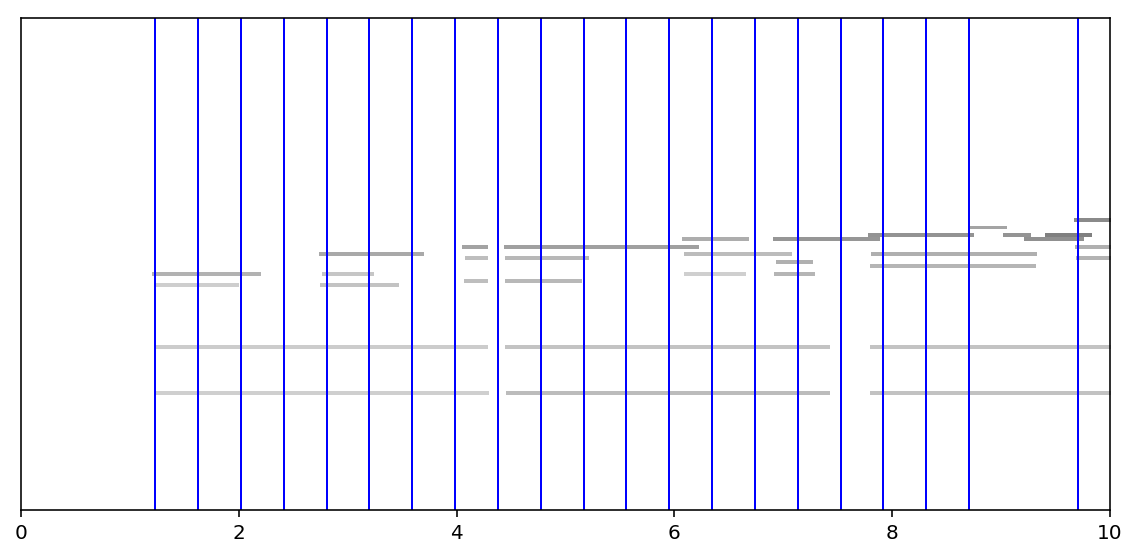

In [263]:
visualize_from_df(291,good_df, (0,10),"beat")

In [268]:
df.groupby("title").count()

author  midi2midi_alignment_path  \
title                                                       
Ballade_2                     1                         1   
Ballades_3                    3                         3   
Berceuse_op_57                5                         5   
Concert_Etude_S145_1          1                         1   
Etudes_op_10_1               26                        26   
Etudes_op_10_2               11                        11   
Etudes_op_10_4               26                        26   
Etudes_op_10_7                3                         3   
Etudes_op_10_8               28                        28   
Etudes_op_25_12               9                         9   
Etudes_op_25_8                4                         4   
Etudes_op_8_11                2                         2   
Fugue_bwv_846                 1                         1   
Fugue_bwv_848                 9                         9   
Fugue_bwv_854                 5                         5   
Fugue_bwv_856                 1                         1   
Fugue_bwv_857                 6                         6   
Fugue_bwv_858                 2                         2   
Fugue_bwv_860                 6                         6   
Fugue_bwv_862                 1                         1   
Fugue_bwv_863                 3                         3   
Fugue_bwv_864                 1                         1   
Fugue_bwv_865                 3                         3   
Fugue_bwv_866                 1                         1   
Fugue_bwv_867                 2                         2   
Fugue_bwv_868                 1                         1   
Fugue_bwv_870                 3                         3   
Fugue_bwv_873                 2                         2   
Fugue_bwv_875                 2                         2   
Fugue_bwv_876                 2                         2   
...                         ...                       ...   
Prelude_bwv_865               3                         3   
Prelude_bwv_866               1                         1   
Prelude_bwv_867               2                         2   
Prelude_bwv_868               1                         1   
Prelude_bwv_870               3                         3   
Prelude_bwv_873               2                         2   
Prelude_bwv_874               3                         3   
Prelude_bwv_875               3                         3   
Prelude_bwv_876               2                         2   
Prelude_bwv_880               3                         3   
Prelude_bwv_883               4                         4   
Prelude_bwv_884               1                         1   
Prelude_bwv_885               6                         6   
Prelude_bwv_887               1                         1   
Prelude_bwv_888               1                         1   
Prelude_bwv_889               6                         6   
Prelude_bwv_891               2                         2   
Prelude_bwv_892               2                         2   
Prelude_bwv_893               3                         3   
Preludes_op_23_2              1                         1   
Preludes_op_32_5              1                         1   
Scherzos_39                   2                         2   
Sonata_2_1st_no_repeat        5                         5   
Sonata_2_3rd                  2                         2   
Sonata_2_3rd_no_repeat        1                         1   
Sonata_2_4th                  3                         3   
Sonata_3_3rd                  9                         9   
The_Lark                      2                         2   
Toccata                      11                        11   
Transcendental_Etudes_9       2                         2   

                         performed_midi_path  performer  score2midi_alignment  \
title                                                                           
Ballade_2          